In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DoubleType
from datetime import datetime

# Initialize Spark session
spark = SparkSession.builder.appName('TripAnalysis').getOrCreate()

# Define the schema
schema = StructType([
    StructField('TripID', StringType(), True),
    StructField('StartTime', TimestampType(), True),
    StructField('EndTime', TimestampType(), True),
    StructField('Distance', DoubleType(), True),
    StructField('Fare', DoubleType(), True)
])

# Create the data and convert StartTime and EndTime to datetime objects
data = [
    ('TRIP001', datetime(2025, 3, 1, 8, 0, 0), datetime(2025, 3, 1, 8, 30, 0), 10.5, 25.00),
    ('TRIP002', datetime(2025, 3, 1, 9, 15, 0), datetime(2025, 3, 1, 9, 45, 0), 8.0, 20.00),
    ('TRIP003', datetime(2025, 3, 1, 10, 0, 0), datetime(2025, 3, 1, 11, 0, 0), 15.2, 35.00),
    ('TRIP004', datetime(2025, 3, 1, 11, 30, 0), datetime(2025, 3, 1, 12, 10, 0), 12.7, 28.00),
    ('TRIP005', datetime(2025, 3, 1, 13, 0, 0), datetime(2025, 3, 1, 13, 25, 0), 7.5, 18.00)
]

# Create DataFrame using the schema
trip_df = spark.createDataFrame(data, schema)

# Show the DataFrame
trip_df.show()


+-------+-------------------+-------------------+--------+----+
| TripID|          StartTime|            EndTime|Distance|Fare|
+-------+-------------------+-------------------+--------+----+
|TRIP001|2025-03-01 08:00:00|2025-03-01 08:30:00|    10.5|25.0|
|TRIP002|2025-03-01 09:15:00|2025-03-01 09:45:00|     8.0|20.0|
|TRIP003|2025-03-01 10:00:00|2025-03-01 11:00:00|    15.2|35.0|
|TRIP004|2025-03-01 11:30:00|2025-03-01 12:10:00|    12.7|28.0|
|TRIP005|2025-03-01 13:00:00|2025-03-01 13:25:00|     7.5|18.0|
+-------+-------------------+-------------------+--------+----+



In [9]:
from pyspark.sql.functions import col, unix_timestamp

# Calculate trip duration in minutes
trip_df = trip_df.withColumn('TripDuration',
    (unix_timestamp('EndTime') - unix_timestamp('StartTime')) / 60)

# Show the DataFrame with TripDuration
trip_df.show()


+-------+-------------------+-------------------+--------+----+------------+
| TripID|          StartTime|            EndTime|Distance|Fare|TripDuration|
+-------+-------------------+-------------------+--------+----+------------+
|TRIP001|2025-03-01 08:00:00|2025-03-01 08:30:00|    10.5|25.0|        30.0|
|TRIP002|2025-03-01 09:15:00|2025-03-01 09:45:00|     8.0|20.0|        30.0|
|TRIP003|2025-03-01 10:00:00|2025-03-01 11:00:00|    15.2|35.0|        60.0|
|TRIP004|2025-03-01 11:30:00|2025-03-01 12:10:00|    12.7|28.0|        40.0|
|TRIP005|2025-03-01 13:00:00|2025-03-01 13:25:00|     7.5|18.0|        25.0|
+-------+-------------------+-------------------+--------+----+------------+



In [10]:
from pyspark.sql.functions import avg

# Calculate fare per mile by dividing Fare by Distance
avg_fare_per_mile = trip_df.withColumn('FarePerMile', col('Fare') / col('Distance'))

# Calculate the average fare per mile across all trips
avg_fare_per_mile = avg_fare_per_mile.agg(avg('FarePerMile').alias('AverageFarePerMile')).collect()[0]['AverageFarePerMile']

print(f'Average fare per mile: {avg_fare_per_mile:.2f}')


Average fare per mile: 2.36


In [11]:
# Sort the DataFrame by Distance in descending order and get the top 3 trips
longest_trips = trip_df.orderBy(col('Distance').desc()).limit(3)

# Show the top 3 longest trips
longest_trips.show()


+-------+-------------------+-------------------+--------+----+------------+
| TripID|          StartTime|            EndTime|Distance|Fare|TripDuration|
+-------+-------------------+-------------------+--------+----+------------+
|TRIP003|2025-03-01 10:00:00|2025-03-01 11:00:00|    15.2|35.0|        60.0|
|TRIP004|2025-03-01 11:30:00|2025-03-01 12:10:00|    12.7|28.0|        40.0|
|TRIP001|2025-03-01 08:00:00|2025-03-01 08:30:00|    10.5|25.0|        30.0|
+-------+-------------------+-------------------+--------+----+------------+



In [12]:
from pyspark.sql.functions import hour

# Extract the hour from StartTime
trip_df = trip_df.withColumn('HourOfDay', hour('StartTime'))

# Group by HourOfDay and count the number of trips
trips_per_hour = trip_df.groupBy('HourOfDay').count().orderBy('HourOfDay')

# Show the number of trips per hour
trips_per_hour.show()


+---------+-----+
|HourOfDay|count|
+---------+-----+
|        8|    1|
|        9|    1|
|       10|    1|
|       11|    1|
|       13|    1|
+---------+-----+



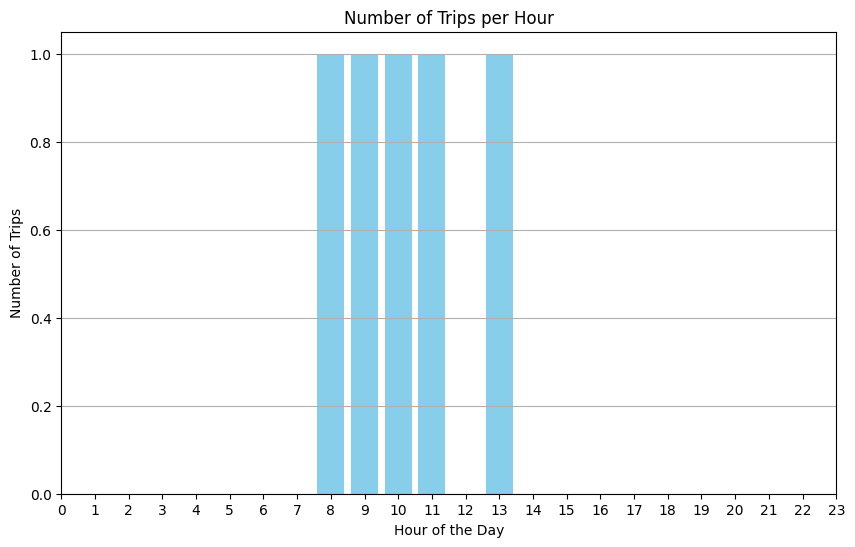

In [13]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
trips_per_hour_pd = trips_per_hour.toPandas()

# Plot the data using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(trips_per_hour_pd['HourOfDay'], trips_per_hour_pd['count'], color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Hour')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()
